In [2]:
import eli5
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBRFClassifier, XGBClassifier
# from jupyterthemes import jtplot


In [4]:
%matplotlib inline
# jtplot.style(grid=False)
pd.set_option('display.max_columns', 50)

In [5]:
%run main.py

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 54: invalid start byte

In [6]:
df = pd.read_csv('model/model_data.csv').set_index('index')

In [7]:
df.head()

,Age range,Race,Income range,Income over $75K,Home ownership,Total number living in household,Employment status,Activity status,Body Mass Index,Diabetic,General Health,Fruit fanaticism,Vegetable voraciousness,Average hours of sleep,Insurance status,Skipped a Dr visit because of money,Last Dr visit,Smoking status,Estimated number of alcoholic drinks per month
index,,,,,,,,,,,,,,,,,,,
41694,80-84,White,$20-25K,False,Own,1.0,Unknown,Unknown,Over,False,Good,Unknown,Unknown,10.0,Unknown,No,Past Year,Never Smoked,30
49527,25-29,Hisp.,Unknown,False,Rent,3.0,Unknown,Unknown,Obese,False,Fair,Unknown,Unknown,6.0,Yes,No,1-2 years,Never Smoked,2
64569,35-39,White,$35-50K,False,Rent,3.0,Unknown,Unknown,Over,False,Very Good,Monthly,Monthly,NaN,Yes,No,1-2 years,Former Smoker,3
5458,25-29,Hisp.,$25-35K,False,Rent,3.0,Employed for wages,Does not meet Aerobic Recs,Obese,False,Fair,Monthly,Monthly,NaN,Yes,No,Past Year,Never Smoked,5
59335,40-44,White,$75+,True,Rent,2.0,Unknown,Unknown,Obese,False,Excellent,Weekly,Monthly,NaN,Yes,No,1-2 years,Never Smoked,4


In [8]:
def train_val_test_split(X, y):
    trainval, test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          random_state=42,
                                                          )
    train, val, y_train, y_val = train_test_split(trainval,
                                                  y_trainval,
                                                  stratify=y_trainval,
                                                  random_state=42)
    return train, val, test, y_train, y_val, y_test

In [9]:
target = 'Diabetic'
y = df[target].astype(bool)
X = df.drop(columns=target)

In [10]:
train, val, test, y_train, y_val, y_test = train_val_test_split(X, y)
train.shape, val.shape, test.shape, y_train.shape, y_val.shape, y_test.shape

((41559, 18), (13854, 18), (18472, 18), (41559,), (13854,), (18472,))

In [11]:
# Predict majority class as baseline.
y.value_counts(normalize=True)

False    0.889071
True     0.110929
Name: Diabetic, dtype: float64

In [12]:
roc_auc_score(y_train, np.full(y_train.shape, 0))

0.5

In [13]:
pipeline = make_pipeline(OrdinalEncoder(),
                         SimpleImputer())

In [14]:
X_train = pipeline.fit_transform(train)
X_val = pipeline.transform(val)
X_test = pipeline.transform(test)
X_train.shape, X_val.shape, X_test.shape

((41559, 18), (13854, 18), (18472, 18))

In [15]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [16]:
model = XGBRFClassifier(n_jobs=-1,
                        n_estimators=5000,
                        early_stopping_rounds=100,
                        random_state=42,
                        scale_pos_weight=15,
                        learning_rate=.005,
                        reg_lambda=.01,
                        verbosity=1)

In [17]:
model.fit(X_train,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          verbose=True)

[0]	validation_0-auc:0.785672	validation_1-auc:0.773351


XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
        colsample_bytree=1, early_stopping_rounds=100, gamma=0,
        learning_rate=0.005, max_delta_step=0, max_depth=3,
        min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
        nthread=None, objective='binary:logistic', random_state=42,
        reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15, seed=None,
        silent=None, subsample=0.8, verbosity=1)

Validation ROC AUC score: 0.7733511120699031


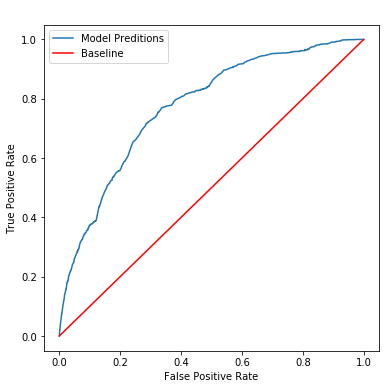

In [20]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
print(f'Validation ROC AUC score: {roc_auc_score(y_val, y_pred_proba)}')
curves = roc_curve(y_val, y_pred_proba)
curve_x, curve_y = curves[0], curves[1]
x_ = np.linspace(0, 1, len(curve_x))
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
y_ = x_
plt.plot(curve_x, curve_y, label='Model Preditions')
plt.plot(x_, y_, color='red', label='Baseline')
plt.title('ROC Curve for initial model.',
          fontsize=16,
          color='white')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.legend()
plt.savefig('roc.png');

In [21]:
permuter = PermutationImportance(model,
                                 cv='prefit',
                                 n_iter=5,
                                 scoring='roc_auc',
                                 random_state=42)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
           estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
        colsample_bytree=1, early_stopping_rounds=100, gamma=0,
        learning_rate=0.005, max_delta_step=0, max_depth=3,
        min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
        nthread=None, objective='binary:logistic', random_state=42,
        reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15, seed=None,
        silent=None, subsample=0.8, verbosity=1),
           n_iter=5, random_state=42, refit=True, scoring='roc_auc')

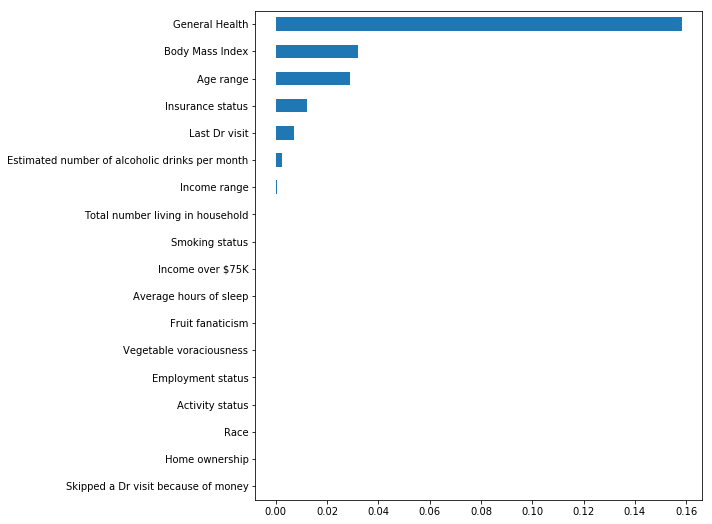

In [22]:
features_of_import = pd.Series(permuter.feature_importances_, val.columns)
plt.figure(figsize=(8, len(val.columns) / 2))
features_of_import.sort_values(ascending=True).plot.barh()
plt.savefig('pretrim.png');

In [23]:
mask = features_of_import > 0
trimmed_columns = train.columns[mask]
train_trimmed = train[trimmed_columns]
val_trimmed = val[trimmed_columns]
test_trimmed = test[trimmed_columns]

pipeline1 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_ = pipeline1.fit_transform(train_trimmed)
X_val_ = pipeline1.transform(val_trimmed)
X_test_ = pipeline1.transform(test_trimmed)

eval_set1 = [(X_train_, y_train),
            (X_val_, y_val)]

In [24]:
model.fit(X_train_, y_train, eval_set=eval_set1, eval_metric='auc')
y_pred_proba = model.predict_proba(X_val_)[:, 1]
print(f'XGBRFClassifier validation ROC AUC: {roc_auc_score(y_val, y_pred_proba)}')

[0]	validation_0-auc:0.783355	validation_1-auc:0.770201
XGBRFClassifier validation ROC AUC: 0.7702009468059364


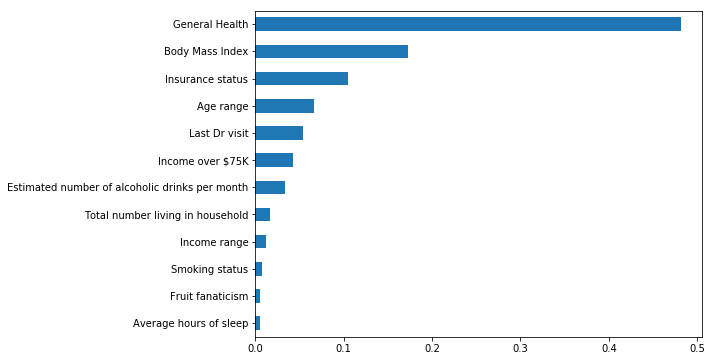

In [25]:
importance = pd.Series(model.feature_importances_, val_trimmed.columns)
plt.figure(figsize=(8, len(val_trimmed.columns) / 2))
importance.sort_values(ascending=True).plot.barh()
plt.savefig('posttrim.png')

In [26]:
# params = {'n_estimators': [100, 500, 1000, 5000, 10000],
#           'scale_pos_weights': [1, 5, 10, 15, 20],
#           'learning_rate': [.0001, .001, .01, .02, .05],
#           'reg_lambda': [.0001, .001, .01, .02, .05]}
# search = RandomizedSearchCV(model,
#                             param_distributions=params,
#                             scoring='roc_auc',
#                             n_iter=50,
#                             cv=5,
#                             n_jobs=-1)
# search.fit(X_train_, y_train)
# search.best_estimator_, search.best_params_, search.best_score_

In [27]:
best = XGBRFClassifier(scale_pos_weights=20,
                       reg_lambda=0.02,
                       n_estimators=10000,
                       learning_rate=0.05,
                       n_jobs=-1,
                       early_stopping_rounds=100,
                       random_state=42,
                       verbosity=1)
best.fit(X_train_, y_train)
y_pred_proba1 = best.predict_proba(X_val_)[:, 1]


In [29]:
class_0, class_1 = unique_labels(y_val)
fpr, tpr, thresholds = roc_curve(y_val==class_1, y_pred_proba1)


In [33]:
to_plotly_pred = pd.DataFrame({'y_val': y_val,
                               'y_pred_proba1': y_pred_proba1})
to_plotly_roc = pd.DataFrame({'fpr': fpr,
                              'tpr': tpr})
to_plotly_pred.to_csv('model/val_data.csv', index_label=False)
to_plotly_roc.to_csv('model/roc_data.csv', index_label=False)

In [105]:
# best = search.best_estimator_
# y_pred_proba1 = best.predict_proba(X_val_)[:, 1]

In [119]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    ax = sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

    return ax

In [122]:
def set_threshold(y_true, y_pred_proba, threshold=.48):
    
    print(f'Threshold: {threshold}')
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.savefig('dist.png')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate:.4f}')
    print(f'False Positive Rate: {false_pos_rate:.4f}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
#     plt.savefig('multi.png')
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba):.4f}')
    
    nice_confusion(y_true, y_pred)
#     plt.savefig('heatmap.png')
    print(classification_report(y_true, y_pred))


Threshold: 0.48


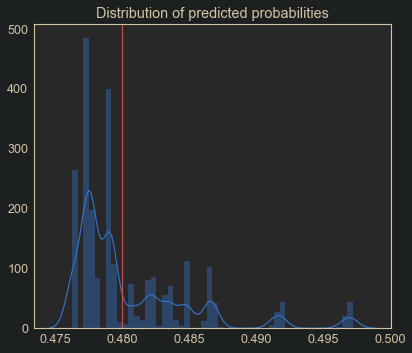

True Positive Rate: 0.6584
False Positive Rate: 0.3170


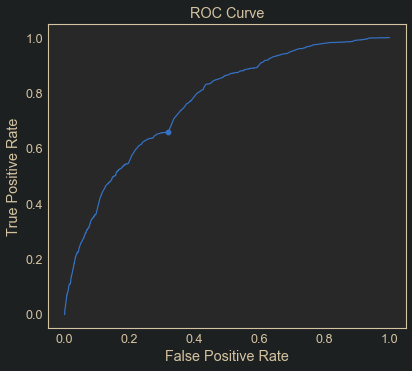

Area under ROC: 0.7661
              precision    recall  f1-score   support

       False       0.94      0.68      0.79     12317
        True       0.21      0.66      0.31      1537

    accuracy                           0.68     13854
   macro avg       0.57      0.67      0.55     13854
weighted avg       0.86      0.68      0.74     13854



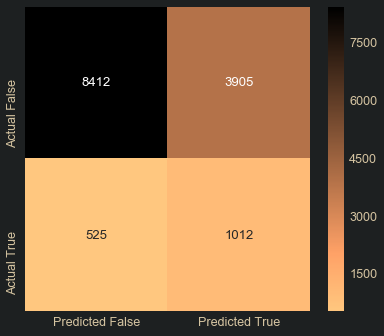

In [123]:
set_threshold(y_val, y_pred_proba1)

In [111]:
threshold = interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba1),
        threshold=(0.47, 0.5, 0.0001));

interactive(children=(FloatSlider(value=0.48, description='threshold', max=0.5, min=0.47, step=0.0001), Output…

In [79]:
pickled_threshold = pickle.dumps(threshold)
pickle.dump(pickled_threshold, open('threshold.p', 'wb'))

Test time!!

In [28]:

test_pred_proba = best.predict_proba(X_test_)[:, 1] > 0.48
print(f'Test ROC AUC: {roc_auc_score(y_test, test_pred_proba)}')

Test ROC AUC: 0.6925781870923621


Find individual instances to examine.

In [29]:
test_trimmed1 = pd.concat([test_trimmed, y_test], axis=1, sort=False)
test_trimmed1.tail(20)

,Age range,Income range,Income over $75K,Total number living in household,Body Mass Index,General Health,Fruit fanaticism,Average hours of sleep,Insurance status,Last Dr visit,Smoking status,Estimated number of alcoholic drinks per month,Diabetic
index,,,,,,,,,,,,,
54070,25-29,Refused,False,4.0,Over,Good,Daily,NaN,Yes,1-2 years,Never Smoked,1,False
71502,70-74,Refused,False,1.0,Normal,Good,Unknown,8.0,Unknown,Past Year,Current - Every Day,8,True
89244,60-64,$50-75K,False,2.0,Over,Excellent,Weekly,NaN,Yes,Past Year,Never Smoked,Unknown,False
15372,80-84,$20-25K,False,1.0,Normal,Fair,Unknown,NaN,Unknown,Past Year,Never Smoked,30,False
22160,60-64,$50-75K,False,2.0,Obese,Good,Unknown,NaN,Yes,Past Year,Former Smoker,Unknown,True
2266,55-59,$50-75K,False,2.0,Over,Very Good,Daily,NaN,Yes,2-5 years,Never Smoked,30,False
13484,30-34,$35-50K,False,3.0,Unknown,Excellent,Weekly,NaN,Yes,1-2 years,Never Smoked,Unknown,False
28437,30-34,< $10K,False,1.0,Normal,Very Good,Unknown,NaN,No,5+ years,Former Smoker,Unknown,False
34222,65-69,$75+,True,2.0,Normal,Good,Daily,6.0,Unknown,Past Year,Never Smoked,Unknown,False


In [30]:
data = test_trimmed1[test_trimmed1.index == 22160]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True True 0.4822771


,Age range,Income range,Income over $75K,Total number living in household,Body Mass Index,General Health,Fruit fanaticism,Average hours of sleep,Insurance status,Last Dr visit,Smoking status,Estimated number of alcoholic drinks per month,Diabetic
index,,,,,,,,,,,,,
22160,60-64,$50-75K,False,2.0,Obese,Good,Unknown,NaN,Yes,Past Year,Former Smoker,Unknown,True


In [31]:
data = test_trimmed1[test_trimmed1.index == 82568]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True False 0.47905847


,Age range,Income range,Income over $75K,Total number living in household,Body Mass Index,General Health,Fruit fanaticism,Average hours of sleep,Insurance status,Last Dr visit,Smoking status,Estimated number of alcoholic drinks per month,Diabetic
index,,,,,,,,,,,,,
82568,70-74,$75+,True,2.0,Normal,Very Good,Daily,NaN,Unknown,Past Year,Former Smoker,28,True


In [32]:
data = test_trimmed1[test_trimmed1.index == 65666]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True True 0.49140975


,Age range,Income range,Income over $75K,Total number living in household,Body Mass Index,General Health,Fruit fanaticism,Average hours of sleep,Insurance status,Last Dr visit,Smoking status,Estimated number of alcoholic drinks per month,Diabetic
index,,,,,,,,,,,,,
65666,40-44,$15-20K,False,4.0,Obese,Fair,None,NaN,Yes,2-5 years,Current - Every Day,Unknown,False


 Start building mechanism to choose parameters for custom predictions.

In [33]:
pickled_pipeline = pickle.dumps(pipeline1)
pickle.dump(pickled_pipeline, open('pipeline.p', 'wb'))

pickled_best = pickle.dumps(best)
pickle.dump(pickled_best, open('estimator.p', 'wb'))

pickled_columns = pickle.dumps(test_trimmed.columns)
pickle.dump(pickled_columns, open('columns.p', 'wb'))

# df.to_csv('data/model_data.csv')


In [35]:
etoh = test_trimmed['Estimated number of alcoholic drinks per month'].value_counts().index.tolist()[1:]
etoh = list(sorted([int(x) for x in etoh]))
etoh = [str(x) for x in etoh]
column_values = {'Age range': list(sorted(test_trimmed['Age range'].value_counts().index.tolist())),
                 'Income range': ['< $10K', 
                                  '$10-15K', 
                                  '$15-20K', 
                                  '$20-25K', 
                                  '$25-30K', 
                                  '$30-35K',
                                  '$35-40K',
                                  '$40-45K',
                                  '$45-50K',
                                  '$50-55K',
                                  '$55-60K',
                                  '$60-65K',
                                  '$65-70K',
                                  '$75+',
                                  'Unknown'
                                   ],
                 'Income over $75K': ['True',
                                      'False'],
                 'Total number living in household': list(sorted(test_trimmed['Total number living in household'].value_counts().index.tolist())),
                 'Body Mass Index': ['Under',
                                     'Normal',
                                     'Over',
                                     'Obese',
                                     'Unknown'],
                 'General Health': ['Excelent',
                                    'Very Good',
                                    'Good',
                                    'Fair',
                                    'Poor',
                                    'Unknown'],
                 'Fruit fanaticism': ['Daily',
                                      'Weekly',
                                      'Monthly',
                                      'None',
                                      'Unknown'],
                 'Average hours of sleep': list(sorted(test_trimmed['Average hours of sleep'].value_counts().index.tolist())),
                 'Insurance status': ['Yes',
                                      'No',
                                      'Unknown'],
                 'Last Dr visit': test_trimmed['Last Dr visit'].value_counts().index.tolist(),
                 'Smoking status': test_trimmed['Smoking status'].value_counts().index.tolist(),
                 'Estimated number of alcoholic drinks per month': etoh, 
                 }
pickled_column_values = pickle.dumps(column_values)
pickle.dump(pickled_column_values, open('column_values.p', 'wb'))


In [ ]:
etoh